In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
import sklearn.cluster
import sklearn.preprocessing
import sklearn.neural_network
import sklearn.linear_model
import sklearn.model_selection
import torch
import torchvision
import torchvision.datasets
import torchvision.models
import torchvision.transforms

In [2]:
# baja y lee los datos
training = torchvision.datasets.FashionMNIST(root="./", train=True, download=True)
train_loader = torch.utils.data.DataLoader(training,shuffle=True)

testing = torchvision.datasets.FashionMNIST(root="./", train=False, download=True, 
                                            transform=torchvision.transforms.Normalize((0), (1.0)))
testing_loader = torch.utils.data.DataLoader(testing, shuffle=True)

In [3]:
# Selecciona y normaliza 600 para entrenar
train  = train_loader.dataset.data[:600].float()
target_train = train_loader.dataset.targets[:600].float()
test =  train_loader.dataset.data[600:1200].float()
target_test = train_loader.dataset.targets[600:1200].float()


mean_train = train.mean(dim=0)
std_train = train.std(dim=0)
std_train[std_train==0]=1.0
mean_test = test.mean(dim=0)
std_test = test.std(dim=0)
std_test[std_test==0]=1.0

for i in range(len(train)):
    train[i] = (train[i]-mean_train)/std_train
    test[i] = (test[i]-mean_test)/std_test
print(np.shape(train))
print(np.shape(target_test))

torch.Size([600, 28, 28])
torch.Size([600])


In [25]:
x_train = train.unsqueeze(1)
n = torch.nn.Conv2d(1, 4, 4, stride=1) # in-channels = 1, out-channels = 4, kernel=4
new_tensor = n(x_train)
print(new_tensor.size())

n = torch.nn.MaxPool2d(kernel_size=3)
feature_maps = n(new_tensor)
print(feature_maps.size())

n = torch.nn.Conv2d(4, 1, 2, stride=1)
feature_maps = n(feature_maps)
print(feature_maps.size())

n = torch.nn.Linear(7,10)
feature_maps = n(feature_maps)
print(feature_maps.size())

n = torch.nn.Flatten()
feature_maps = n(feature_maps)
print(feature_maps.size())
n = torch.nn.Linear(70,10)
feature_maps = n(feature_maps)
print(feature_maps.size())


torch.Size([600, 4, 25, 25])
torch.Size([600, 4, 8, 8])
torch.Size([600, 1, 7, 7])
torch.Size([600, 1, 7, 10])
torch.Size([600, 70])
torch.Size([600, 10])


In [28]:

model1 = torch.nn.Sequential(
    torch.nn.Conv2d(1, 4, kernel_size=4, stride=1),
    torch.nn.MaxPool2d(kernel_size=3),
    torch.nn.Conv2d(4, 1, kernel_size=2, stride=1),
    torch.nn.Linear(7, 10),
    torch.nn.Flatten(),
    torch.nn.Linear(70,10)
)


criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model1.parameters(), lr=0.1) #lr: learning rate
epochs = 60
loss_values = np.zeros(epochs)
F1_values_train = np.zeros(epochs)
F1_values_test = np.zeros(epochs)


for epoch in range(epochs):
    x_train = train.unsqueeze(1)
    inputs = torch.autograd.Variable(torch.Tensor(x_train).float())
    targets = torch.autograd.Variable(torch.Tensor(target_train).long())
    
    optimizer.zero_grad()
    out = model1(inputs)
    loss = criterion(out, targets)
    loss.backward()
    optimizer.step()
    
    values, Y_predicted = torch.max(out.data, 1)
    loss_values[epoch] = loss.item()
    F1_values_train[epoch] = sklearn.metrics.f1_score(target_train, Y_predicted, average='macro')
    
    X_new = np.expand_dims(test, 1)
    inputs_test = torch.autograd.Variable(torch.Tensor(X_new).float())
    out_test = model1(inputs_test)
    values, Y_predicted_test = torch.max(out_test.data, 1)
    F1_values_test[epoch] = sklearn.metrics.f1_score(target_test, Y_predicted_test, average='macro')

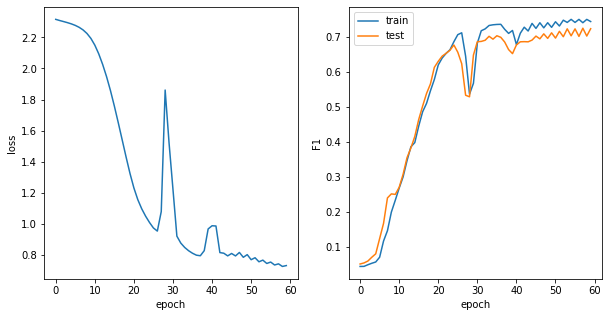

In [29]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(np.arange(epochs), loss_values)
plt.xlabel('epoch')
plt.ylabel('loss')


plt.subplot(1,2,2)
plt.plot(np.arange(epochs), F1_values_train, label='train')
plt.plot(np.arange(epochs), F1_values_test, label='test')
plt.xlabel('epoch')
plt.ylabel('F1')
plt.legend()